# Gated Attention - Quick Test w/ a Rectified Flow Latent DiT

As a little exercise for myself I made a from-scratch transformer implementation to play with for image-gen stuff. Here, I test the idea from [Gated Attention for Large Language Models: Non-linearity, Sparsity, and Attention-Sink-Free](http://arxiv.org/abs/2505.06708) of adding a sigmoid gate just after the SDPA in the transformer block.

In [ ]:
import math, torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from matplotlib import pyplot as plt
from einops import rearrange, repeat

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Transformer Block

In [ ]:
class RMSNorm(nn.Module):
    """Pre‑norm layer normalisation with learned scale (no bias)."""
    def __init__(self, dim, eps: float = 1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps

    def forward(self, x):
        rms = x.norm(dim=-1, keepdim=True) * (x.shape[-1] ** -0.5)
        return self.weight * (x / (rms + self.eps))

In [ ]:
class RotaryEmbeddings(nn.Module):
    """Pre‑computes rotary position embeddings (RoPE)."""
    def __init__(self, dim, base=10000):
        super().__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

    def forward(self, seq_len, device):
        t = torch.arange(seq_len, device=device).type_as(self.inv_freq)
        freqs = torch.einsum("i , j -> i j", t, self.inv_freq)           # [seq, dim/2]
        emb = torch.cat((freqs.sin(), freqs.cos()), dim=-1)              # [seq, dim]
        return emb[None, :, None, :]                                     # [1, seq, 1, dim]

In [ ]:
def apply_rope(x, rope):
    # x : [b, seq, h, d]; rope : [1, seq, 1, d]
    x1, x2 = x[..., ::2], x[..., 1::2]
    sin, cos = rope[..., ::2], rope[..., 1::2]
    return torch.cat((x1 * cos - x2 * sin, x1 * sin + x2 * cos), dim=-1)

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, head_dim=None, bias=False, use_gate=False):
      super().__init__()
      self.num_heads = num_heads
      self.head_dim  = head_dim or dim // num_heads
      self.scale     = self.head_dim ** -0.5
      self.qkv = nn.Linear(dim, (num_heads + 2) * self.head_dim, bias=bias)  # GQA: separate q; shared kv
      self.proj = nn.Linear(num_heads * self.head_dim, dim, bias=bias)
      self.rope = RotaryEmbeddings(self.head_dim)
      self.use_gate = use_gate
      if self.use_gate: # one-layer “output-gate” (σ(W x) ⊙ x) applied to the concatenated heads
        self.gate_proj = nn.Linear(num_heads * self.head_dim,num_heads * self.head_dim, bias=True)

    def forward(self, x, mask=None):
      B, L, _ = x.shape
      qkv = self.qkv(x)                  # [B, L, (h+2)·d]
      q, kv = qkv.split([self.num_heads * self.head_dim, 2 * self.head_dim], dim=-1)
      q = rearrange(q, "b l (h d) -> b l h d", h=self.num_heads)  # [B,L,H,d]
      k, v = kv.chunk(2, dim=-1) # Produce k and v, each [B, L, d]  (shared across all heads)
      rope = self.rope(L, x.device)         # [1, L, 1, d]
      q = apply_rope(q, rope)               # [B,L,H,d]
      k = apply_rope(k.unsqueeze(2), rope).squeeze(2)   # [B,L,d]
      scores = torch.einsum("b l h d, b m d -> b h l m", q, k) * self.scale
      if mask is not None: scores = scores.masked_fill(mask == 0, float("-inf"))
      attn = torch.softmax(scores, dim=-1)
      out = torch.einsum("b h l m, b m d -> b l h d", attn, v)
      out = rearrange(out, "b l h d -> b l (h d)")

      # --------------- G1 OUTPUT-GATE ------------------
      if self.use_gate:
        gate = torch.sigmoid(self.gate_proj(out))     # same size as out
        out  = out * gate                             # element-wise ⊙
      # ------------------------------------------------

      return self.proj(out)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_mult=8/3, bias=False):
        super().__init__()
        hidden = int(dim * hidden_mult)          # Llama uses ~2.67×, we keep 8/3
        self.w1 = nn.Linear(dim, hidden*2, bias=bias)  # fused SwiGLU (w1 splits into gate+up)
        self.w2 = nn.Linear(hidden, dim, bias=bias)

    def forward(self, x):
        gate, up = self.w1(x).chunk(2, dim=-1)
        return self.w2(F.silu(gate) * up)        # SwiGLU

class TransformerBlock(nn.Module):
    """
    Basic transformer block:
      • rmsnorm -> attention -> residual
      • rmsnorm -> SwiGLU MLP -> residual
    """
    def __init__(self, dim, num_heads=8, bias=False, gate_attn=False):
        super().__init__()
        self.attn_norm = RMSNorm(dim)
        self.attn = Attention(dim, num_heads, bias=bias, use_gate=gate_attn)
        self.ffn_norm = RMSNorm(dim)
        self.ffn = FeedForward(dim, bias=bias)

    def forward(self, x, mask=None):
        x = x + self.attn(self.attn_norm(x), mask=mask)
        x = x + self.ffn(self.ffn_norm(x))
        return x

In [ ]:
# Sanity check:
torch.manual_seed(0)
B, L, D = 2, 16, 256
x = torch.randn(B, L, D)
block = TransformerBlock(D, num_heads=8)
y = block(x)        # [B, L, D]
print(y.shape)

torch.Size([2, 16, 256])


## Image Patch Transformer (w/ optional causal mask)

In [ ]:
class PatchEmbed(nn.Module):
  """
  Image → sequence of patch tokens (ViT style).
    • Each patch is flattened then linearly projected to `dim`.
  """
  def __init__(self, img_size, patch_size, in_chans, dim):
    super().__init__()
    assert img_size % patch_size == 0, "img_size must be divisible by patch_size"
    self.patch_size = patch_size
    self.n_patches  = (img_size // patch_size) ** 2
    self.proj = nn.Linear(in_chans * patch_size ** 2, dim, bias=False)

  def forward(self, x):
    # x : [B, C, H, W]
    patches = rearrange(
        x, "b c (h p1) (w p2) -> b (h w) (c p1 p2)",
        p1=self.patch_size, p2=self.patch_size
    )
    return self.proj(patches)                # [B, n_patches, dim]

class PatchDecoder(nn.Module):
  """Sequence of tokens → reconstructed image."""
  def __init__(self, img_size, patch_size, out_chans, dim):
    super().__init__()
    self.patch_size = patch_size
    self.img_size   = img_size
    self.out_chans  = out_chans
    self.proj = nn.Linear(dim, out_chans * patch_size ** 2, bias=False)

  def forward(self, tokens):
    # tokens : [B, n_patches, dim]
    patches = self.proj(tokens)
    x = rearrange(
        patches,
        "b (h w) (c p1 p2) -> b c (h p1) (w p2)",
        h=self.img_size // self.patch_size,
        w=self.img_size // self.patch_size,
        p1=self.patch_size, p2=self.patch_size, c=self.out_chans
    )
    return x                                  # [B, C, H, W]

class ImageTransformer(nn.Module):
    """
    • Patch‑embeds input image
    • Several TransformerBlocks
    • Decodes back to image in pixel space
    It’s *bidirectional* (no causal masking).
    Pass optional class (out of n_classes) and timestep t (0-1) as conditioning
    """
    def __init__(
        self,
        img_size      : int  = 128,
        patch_size    : int  = 16,
        in_chans      : int  = 3,
        embed_dim     : int  = 256,
        depth         : int  = 8,
        num_heads     : int  = 8,
        n_classes     : int  = 1000,
        gate_attn=False
    ):
        super().__init__()
        self.embed  = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, num_heads, gate_attn=gate_attn) for _ in range(depth)]
        )
        self.decode = PatchDecoder(img_size, patch_size, in_chans, embed_dim)

        self.class_embed = nn.Embedding(n_classes, embed_dim)
        self.timestep_embed = nn.Embedding(100, embed_dim) # We use closest 100 of t

        # Weight init
        def llama_init(module, n_layers: int):
          """
          Apply Llama‑style init to a single sub‑module.
          Call   model.apply(lambda m: llama_init(m, depth))
          right after creating the module tree.
          """
          if isinstance(module, nn.Linear):
            # residual‑path scaling (see §2.3 in the original GPT‑3 paper,
            # also used by Llama; factor √2 for RMSNorm on both sides)
            std = 0.02 / math.sqrt(2 * n_layers) # 0.02 constant—larger models (> 1 B params) often use 0.01—but the scaling with √(layers) (and the √2 for pre‑norm) is what really matters for signal propagation.
            init.trunc_normal_(module.weight, std=std, a=-2*std, b=2*std)
            if module.bias is not None:
              init.zeros_(module.bias)

          elif isinstance(module, RMSNorm):
            init.ones_(module.weight)

        self.apply(lambda m: llama_init(m, depth))

    def forward(self, x, c=0, t=0):
        tok = self.embed(x)                       # [B, N, D]
        # Embed class (c) and timestep int(t*100) and add as extra 'tokens' in first and second place respectively:
        tok = torch.cat([self.class_embed(c).unsqueeze(1), tok], dim=1)
        tok = torch.cat([self.timestep_embed((t*100).int()).unsqueeze(1), tok], dim=1)
        for block in self.blocks: tok = block(tok, mask=None)
        return self.decode(tok[:, 2:])                   # same shape as input image

In [ ]:
# Sanity check (Can try causal = True too)
B, C, H = 2, 3, 128
img = torch.randn(B, C, H, H)
t = torch.rand(B)
c = torch.randint(0, 1000, (B,))
net = ImageTransformer(img_size=H)
out = net(img, c, t)
print(out.shape)       # (B,C,H,H)

torch.Size([2, 3, 128, 128])


# Dataset

In [ ]:
# Pro tip : use `hf_transfer` to get faster download speed.
# !pip install hf_transfer; export HF_HUB_ENABLE_HF_TRANSFER=True; huggingface-cli download --repo-type dataset cloneofsimo/imagenet.int8 --local-dir ./vae_mds

In [ ]:
# !pip install mosaicml-streaming # Don't like that this downloads new cuda stuff :/

In [ ]:
from streaming.base.format.mds.encodings import Encoding, _encodings
import numpy as np
from typing import Any
import torch
from streaming import StreamingDataset

class uint8(Encoding):
    def encode(self, obj: Any) -> bytes:
        return obj.tobytes()

    def decode(self, data: bytes) -> Any:
        x=  np.frombuffer(data, np.uint8).astype(np.float32)
        return (x / 255.0 - 0.5) * 24.0

_encodings["uint8"] = uint8

remote_train_dir = "./vae_mds" # this is the path you installed this dataset.
local_train_dir = "./local_train_dir"

train_dataset = StreamingDataset(
    local=local_train_dir,
    remote=remote_train_dir,
    split=None,
    shuffle=True,
    shuffle_algo="naive",
    num_canonical_nodes=1,
    batch_size = 32
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=3,
)

In [ ]:
b = next(iter(train_dataloader))
y = b['label'] # Class
yt = b['label_as_text']
x = b['vae_output']
print(x.shape)

torch.Size([64, 4096])


In [ ]:
32*32*4

4096

In [ ]:
print(yt)

['toilet seat', 'radiator', 'muzzle', 'crane', 'guinea pig, Cavia cobaya', 'acoustic guitar', 'toilet seat', 'ambulance', 'Newfoundland, Newfoundland dog', 'wing', 'car wheel', 'dough', 'puck, hockey puck', 'slug', 'sandbar, sand bar', 'spatula', 'broom', 'vestment', 'bullfrog, Rana catesbeiana', 'horizontal bar, high bar', 'baboon', 'brain coral', 'greenhouse, nursery, glasshouse', 'fountain', 'custard apple', 'letter opener, paper knife, paperknife', 'Yorkshire terrier', 'bull mastiff', 'Boston bull, Boston terrier', 'Pomeranian', 'Egyptian cat', 'velvet', 'tree frog, tree-frog', 'nail', 'Boston bull, Boston terrier', 'brown bear, bruin, Ursus arctos', 'meerkat, mierkat', 'church, church building', 'lab coat, laboratory coat', 'bittern', 'slug', 'web site, website, internet site, site', 'king snake, kingsnake', 'snow leopard, ounce, Panthera uncia', 'stretcher', 'ibex, Capra ibex', 'doormat, welcome mat', 'garden spider, Aranea diademata', 'sunglasses, dark glasses, shades', 'suit, s

In [ ]:
# b['label']

# Training a rectified flow model with this

In [ ]:
from tqdm.auto import tqdm

In [ ]:
model = ImageTransformer(
    img_size   = 32,
    patch_size = 2,
    in_chans   = 4,
    embed_dim  = 768,
    depth      = 16,
    num_heads  = 12,
    gate_attn  = False
)
model.train()
model.to(device)

opt = torch.optim.AdamW(model.parameters(), lr=3e-4)
losses = []

# First batch for eval:
eval_batch = next(iter(train_dataloader))
eval_bs=eval_batch['vae_output'].shape[0]
eval_t = torch.arange(0, 1, step=1/eval_bs).to(device)
eval_x = eval_batch['vae_output'].reshape(-1, 4, 32, 32).to(device)
eval_c = torch.tensor([int(c) for c in eval_batch['label']]).to(device)
eval_t_expanded = eval_t.view([eval_bs, *([1] * len(eval_x.shape[1:]))])
eval_z1 = torch.randn(eval_x.shape).to(eval_x.device)
eval_z_t = (1 - eval_t_expanded) * eval_x + eval_t_expanded * eval_z1
eval_losses = []

for i, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
  c = torch.tensor([int(c) for c in batch['label']]).to(device) # class
  yt = batch['label_as_text']
  x = batch['vae_output'].reshape(-1, 4, 32, 32).to(device)

  # Inspired by auraflow
  b = x.size(0)
  t = torch.rand((b,)).to(x.device)
  t_expanded = t.view([b, *([1] * len(x.shape[1:]))])
  z_1 = torch.randn(x.shape).to(x.device)
  z_t = (1 - t_expanded) * x + t_expanded * z_1
  vtheta = model(z_t, c=c, t=t)  # predict z_1 - x.
  loss = ((z_1 - x - vtheta) ** 2).mean()
  # Skipping TV loss etc
  opt.zero_grad()
  loss.backward()
  opt.step()
  losses.append(loss.item())

  if i % 100 == 0:
    with torch.no_grad():
      eval_vtheta = model(eval_z_t, c=eval_c, t=eval_t)
      eval_loss = ((eval_z1 - eval_x - eval_vtheta) ** 2).mean()
      print(f"most recent eval loss: {eval_loss.item()} (train loss {losses[-1]})")
      eval_losses.append(eval_loss.item())

  # if i > 3000: break # Optional early stop

  0%|          | 0/20019 [00:00<?, ?it/s]

most recent eval loss: 32.767311096191406 (train loss 30.47293472290039)
most recent eval loss: 16.244384765625 (train loss 16.227203369140625)
most recent eval loss: 9.785066604614258 (train loss 10.24185562133789)
most recent eval loss: 8.221638679504395 (train loss 8.362272262573242)
most recent eval loss: 7.800429344177246 (train loss 7.156425476074219)
most recent eval loss: 7.327062606811523 (train loss 6.580838680267334)
most recent eval loss: 7.0479865074157715 (train loss 7.55086612701416)
most recent eval loss: 7.046558380126953 (train loss 6.701945781707764)
most recent eval loss: 6.819748878479004 (train loss 6.859722137451172)
most recent eval loss: 6.807093143463135 (train loss 8.07313346862793)
most recent eval loss: 6.738161087036133 (train loss 6.41855525970459)
most recent eval loss: 6.622105598449707 (train loss 5.897930145263672)
most recent eval loss: 6.697108268737793 (train loss 8.027281761169434)
most recent eval loss: 6.551443576812744 (train loss 7.35024452209

KeyboardInterrupt: 

In [ ]:
eval_z1.shape, eval_x.shape, eval_t_expanded.shape, eval_t.shape

In [ ]:
# # Save losses and eval losses with pickle
# import pickle
# with open('g_losses.pkl', 'wb') as f:
#     pickle.dump(losses, f)
# with open('g_eval_losses.pkl', 'wb') as f:
#     pickle.dump(eval_losses, f)

In [ ]:
# import pickle
# with open('losses.pkl', 'wb') as f:
#     pickle.dump(losses, f)
# with open('eval_losses.pkl', 'wb') as f:
#     pickle.dump(eval_losses, f)

In [ ]:
# Plot and compare the two
# Base
with open('losses.pkl', 'rb') as f:
    losses = pickle.load(f)
with open('eval_losses.pkl', 'rb') as f:
    eval_losses = pickle.load(f)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(losses)
axs[0].set_title('Training Loss')
axs[1].plot(eval_losses)
axs[1].set_title('Evaluation Loss')

# Gated version
with open('g_losses.pkl', 'rb') as f:
    losses = pickle.load(f)
with open('g_eval_losses.pkl', 'rb') as f:
    eval_losses = pickle.load(f)

axs[0].plot(losses)
axs[1].plot(eval_losses)

plt.legend(['Base', 'Gated']);

In [ ]:
# 5.8 its/sec non-SPDA

# TODO:

- Class conditioning
- Try larger model
- Sampling
- Diff learning rates
- Compare gated vs not
- Save models for later experiments
- Try larger models (e.g. 512 embed and 12 layers -> 30M from 5 now)
- W&B logging
- Crank size and LR to get instabilities
- Look up patch size ideas for latent DiTs...
- Val loss on fixed ts

# Sampling

In [ ]:
from diffusers.models import AutoencoderKL
from diffusers.image_processor import VaeImageProcessor
vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae").to("cuda:0")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [ ]:
def sample( z, c, sample_steps=50, cfg=2.0):
  with torch.no_grad():
    # Simple ODE sampling
    b = z.size(0)
    dt = 1.0 / sample_steps
    dt = torch.tensor([dt] * b).to(z.device).view([b, *([1] * len(z.shape[1:]))])
    images = [z]
    for i in range(sample_steps, 0, -1):
      t = i / sample_steps
      t = torch.tensor([t] * b).to(z.device).clip(0, 0.999) # Can't handle 1 in tembed
      vc = model(z, c=c, t=t)
      z = z - dt * vc
      images.append(z)
    return images

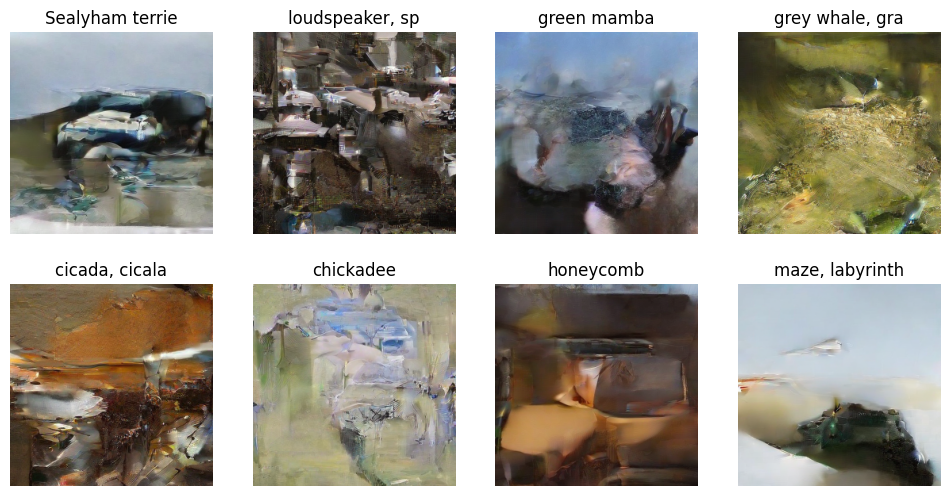

In [ ]:
c = torch.tensor([int(c) for c in eval_batch['label']][:8]).to(device)
labels = eval_batch['label_as_text'][:8]
z = torch.randn(8, 4, 32, 32).to(device)
samples = sample(z, c, sample_steps=100)
with torch.no_grad():
  x = vae.decode(samples[-1].cuda()).sample
  imgs = VaeImageProcessor().postprocess(image = x.detach(), do_denormalize = [True]*8)
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, im in enumerate(imgs):
  axs[i // 4,  i % 4].imshow(im)
  axs[i // 4,  i % 4].axis('off')
  axs[i // 4,  i % 4].set_title(labels[i][:15])
plt.show()

In [ ]:
labels

In [ ]:
c.shape, t.shape, z.shape

I'm using out to modulate the gate, they try lots of things, the most promising being q. From o3, untested:

```python
# in Attention.__init__
self.use_gate = use_gate
if use_gate:
    # query-dependent: project from model dim -> H*d
    self.gate_proj = nn.Linear(dim, self.num_heads * self.head_dim, bias=True)

# in Attention.forward(...)
x_q = x                       # pre-norm hidden state is the caller’s input
...
out = rearrange(out, "b l h d -> b l (h d)")

if self.use_gate:
    gate = torch.sigmoid(self.gate_proj(x_q))   # [B,L,H*d]
    out  = out * gate                           # query-dependent gate
```

(If you prefer head-wise instead of element-wise, project to num_heads and reshape/broadcast.)

Everything else (sigmoid, multiplicative, placed right after SDPA) stays exactly as in the patch.

In [ ]:
# Long run
import pickle
with open('llosses.pkl', 'wb') as f:
    pickle.dump(losses, f)
with open('leval_losses.pkl', 'wb') as f:
    pickle.dump(eval_losses, f)

Text(0.5, 1.0, 'Evaluation Loss')

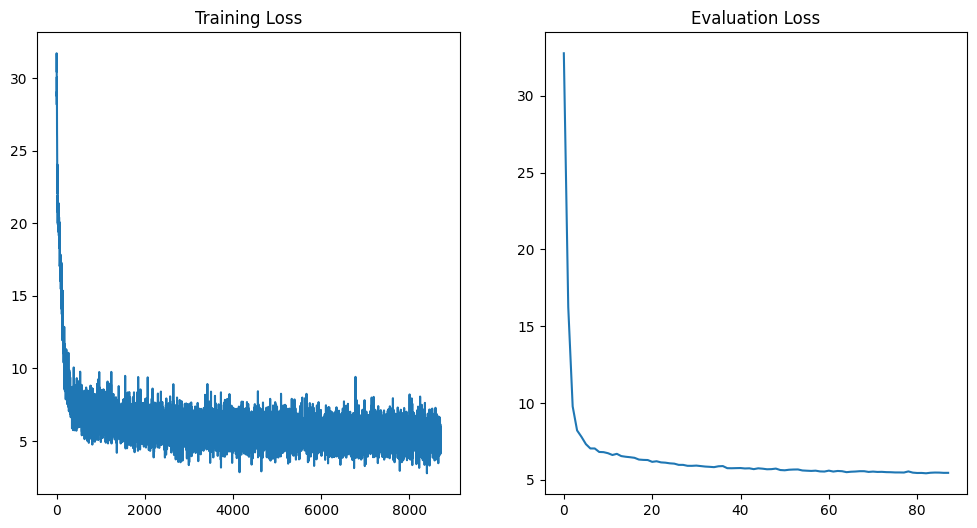

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(losses)
axs[0].set_title('Training Loss')
axs[1].plot(eval_losses)
axs[1].set_title('Evaluation Loss')

(1.4, 3.0)

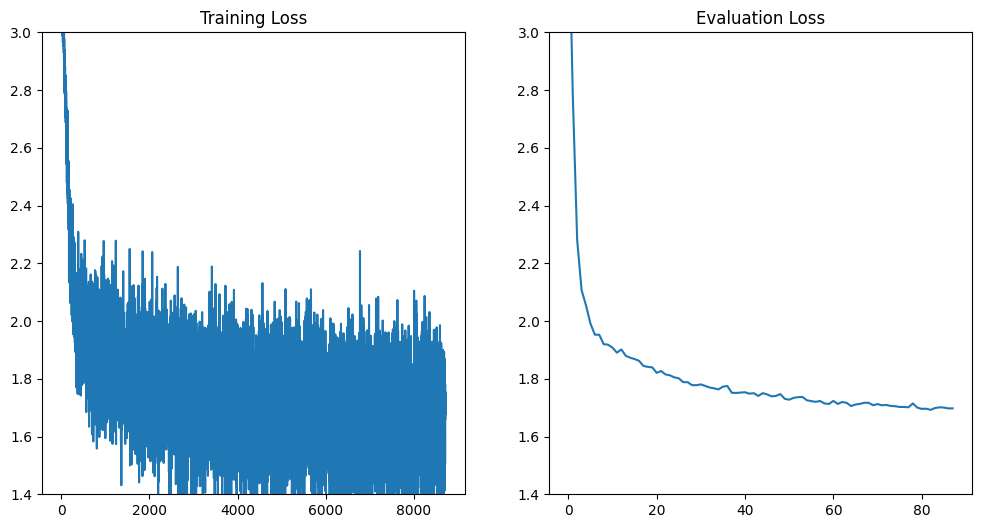

In [ ]:
# Log y axis version, shared y axis
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(np.log(losses))
axs[0].set_title('Training Loss')
axs[1].plot(np.log(eval_losses))
axs[1].set_title('Evaluation Loss')
axs[0].set_ylim(1.4, 3)
axs[1].set_ylim(1.4, 3)

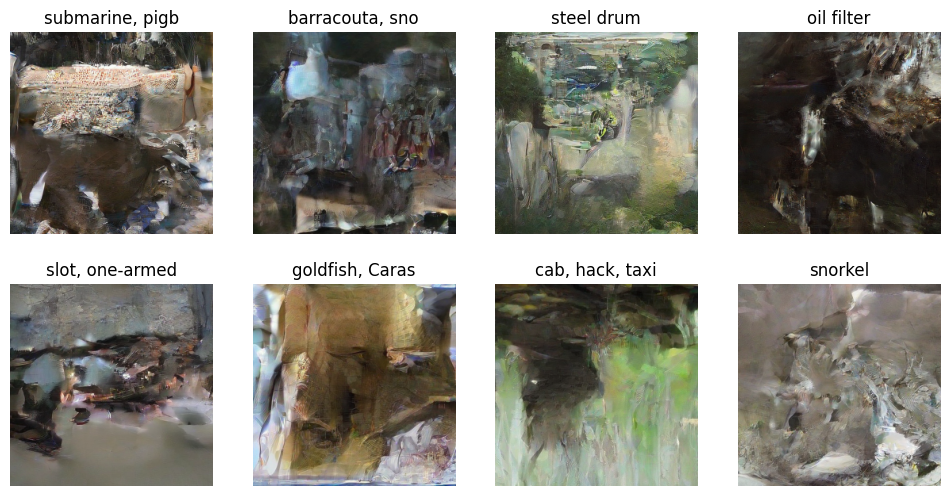

In [ ]:
c = torch.tensor([int(c) for c in eval_batch['label']][:8]).to(device)
labels = eval_batch['label_as_text'][8:16]
z = torch.randn(8, 4, 32, 32).to(device)
samples = sample(z, c, sample_steps=100)
with torch.no_grad():
  x = vae.decode(samples[-1].cuda()).sample
  imgs = VaeImageProcessor().postprocess(image = x.detach(), do_denormalize = [True]*8)
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, im in enumerate(imgs):
  axs[i // 4,  i % 4].imshow(im)
  axs[i // 4,  i % 4].axis('off')
  axs[i // 4,  i % 4].set_title(labels[i][:15])
plt.show()

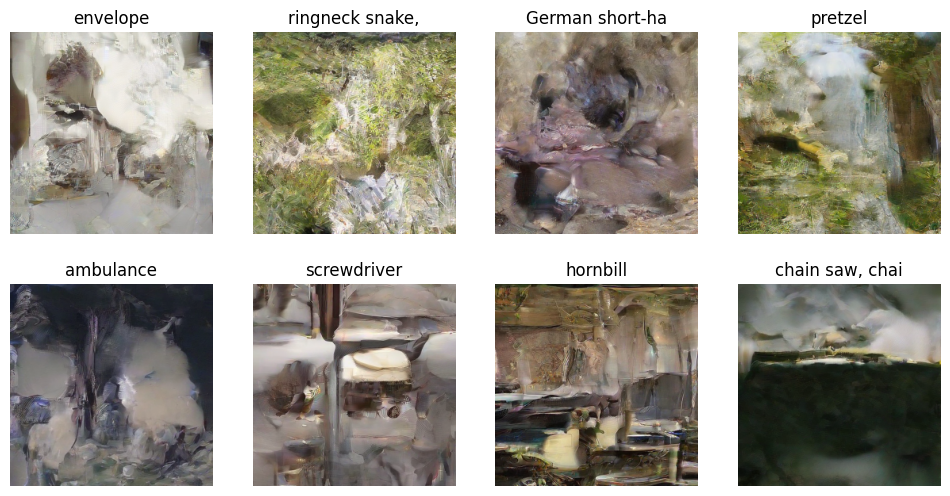

In [ ]:
c = torch.tensor([int(c) for c in eval_batch['label']][:8]).to(device)
labels = eval_batch['label_as_text'][16:24]
z = torch.randn(8, 4, 32, 32).to(device)
samples = sample(z, c, sample_steps=100)
with torch.no_grad():
  x = vae.decode(samples[-1].cuda()).sample
  imgs = VaeImageProcessor().postprocess(image = x.detach(), do_denormalize = [True]*8)
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, im in enumerate(imgs):
  axs[i // 4,  i % 4].imshow(im)
  axs[i // 4,  i % 4].axis('off')
  axs[i // 4,  i % 4].set_title(labels[i][:15])
plt.show()